<a href="https://colab.research.google.com/github/Pr1yansh1/Causal-Analysis-Recidivism/blob/main/pgm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dowhy
!pip install dowhy
!sudo apt-get install libglpk-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglpk-dev is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
# activate R magic
%load_ext rpy2.ipython

# Install R package Matching
%R install.packages('Matching') # For generic matching

# Install R package rgenoud
%R install.packages('rgenoud') # For generic matching

# Install R package MatchIt
%R install.packages('MatchIt')

# Install R package optmatch
%R install.packages('optmatch') # for optimal matching

# Install R package Rglpk
%R install.packages('Rglpk', dependencies=TRUE) # for cardinality matching

(as ‘lib’ is unspecified)



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython








	‘/tmp/RtmpMIrEvR/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpMIrEvR/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpMIrEvR/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpMIrEvR/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpMIrEvR/downloaded_packages’



In [ ]:
# Package to create synthetic data for causal inference
from dowhy import datasets

# Data processing
import pandas as pd
import numpy as np

# Python to R conversion
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Import R libraries
Matching = importr('Matching')
rgenoud = importr('rgenoud')
MatchIt = importr('MatchIt')
optmatch = importr('optmatch')
Rglpk = importr('Rglpk')

# Read R libraries
%R library(Matching) # For genetic matching
%R library(rgenoud) # For genetic matching
%R library(MatchIt)
%R library(optmatch) # For optimal matching
%R library(Rglpk) # For cardinality matching

'ggplot2','dplyr','Rglpk',...,'datasets','methods','base'


In [ ]:
%%R
# Loading data
library(dplyr)
library(ggplot2)
raw_data <- read.csv("./compas-scores-two-years.csv")
nrow(raw_data)

[1] 7214


In [ ]:
%%R
# Cleaning data
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count,
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>%
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
nrow(df)

[1] 6172


#Treatment: Gender#

In [ ]:
%%R
# Changing variables into factors
df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>%
      mutate(race_factor = factor(race)) %>%
      within(race_factor <- relevel(race_factor, ref = 3)) %>%
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
      mutate(recid_factor = factor(is_recid))
model <- glm(recid_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df)
summary(model)


Call:
glm(formula = recid_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -3.21693    0.18515 -17.375  < 2e-16 ***
gender_factorFemale          -0.71221    0.23476  -3.034  0.00242 ** 
age_factorGreater than 45    -0.48558    0.21292  -2.281  0.02257 *  
age_factorLess than 25        0.47151    0.19686   2.395  0.01661 *  
race_factorAfrican-American   0.39677    0.17900   2.217  0.02665 *  
race_factorAsian              0.70906    0.76041   0.932  0.35109    
race_factorHispanic          -0.60901    0.38717  -1.573  0.11572    
race_factorNative American    1.28086    1.11148   1.152  0.24916    
race_factorOther             -0.41378    0.43935  -0.942  0.34629    
priors_count                  0.09805    0.01693   5.791 6.99e-09 ***
crime_factorM                 0.16273    0.16147

In [ ]:
%%R
# Full matching, treatment = gender
full_match <- matchit(gender_factor ~ race_factor + age_factor +
    priors_count + crime_factor + two_year_recid, data=df, method="full")

# Summary of full matching results
summary(full_match, un = FALSE)


Call:
matchit(formula = gender_factor ~ race_factor + age_factor + 
    priors_count + crime_factor + two_year_recid, data = df, 
    method = "full")

Summary of Balance for Matched Data:
                            Means Treated Means Control Std. Mean Diff.
distance                           0.2123        0.2123         -0.0001
race_factorCaucasian               0.4102        0.3870          0.0472
race_factorAfrican-American        0.4672        0.4707         -0.0070
race_factorAsian                   0.0017        0.0022         -0.0114
race_factorHispanic                0.0698        0.0761         -0.0248
race_factorNative American         0.0017        0.0027         -0.0246
race_factorOther                   0.0494        0.0613         -0.0552
age_factor25 - 45                  0.5864        0.5605          0.0526
age_factorGreater than 45          0.2043        0.2147         -0.0258
age_factorLess than 25             0.2094        0.2249         -0.0381
priors_count      

In [ ]:
%%R
# Genetic matching
genetic_match <- matchit(gender_factor ~ age_factor + race_factor +
    priors_count + crime_factor + two_year_recid, data=df, method="genetic")

# Summary of genetic matching
summary(genetic_match, un = FALSE)

Exception ignored from cffi callback <function _processevents at 0x7bde0dc5e5f0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 278, in _processevents
    processevents()
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 262, in processevents
    def processevents() -> None:
KeyboardInterrupt: 



Call:
matchit(formula = gender_factor ~ age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, data = df, 
    method = "genetic")

Summary of Balance for Matched Data:
                            Means Treated Means Control Std. Mean Diff.
distance                           0.2123        0.2123          0.0008
age_factor25 - 45                  0.5864        0.5864          0.0000
age_factorGreater than 45          0.2043        0.2043          0.0000
age_factorLess than 25             0.2094        0.2094          0.0000
race_factorCaucasian               0.4102        0.4102          0.0000
race_factorAfrican-American        0.4672        0.4672          0.0000
race_factorAsian                   0.0017        0.0017          0.0000
race_factorHispanic                0.0698        0.0698          0.0000
race_factorNative American         0.0017        0.0017          0.0000
race_factorOther                   0.0494        0.0494          0.0000
priors_count   

In [ ]:
%%R
# Coarsened exact matching
coarsened_exact_match <- matchit(gender_factor ~ age_factor + race_factor +
    priors_count + crime_factor + two_year_recid, data=df, method="cem")

# Summary of coarsened exact matching
summary(coarsened_exact_match, un = FALSE)


Call:
matchit(formula = gender_factor ~ age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, data = df, 
    method = "cem")

Summary of Balance for Matched Data:
                            Means Treated Means Control Std. Mean Diff.
age_factor25 - 45                  0.5875        0.5875          0.0000
age_factorGreater than 45          0.2024        0.2024          0.0000
age_factorLess than 25             0.2101        0.2101          0.0000
race_factorCaucasian               0.4091        0.4091          0.0000
race_factorAfrican-American        0.4708        0.4708          0.0000
race_factorAsian                   0.0009        0.0009          0.0000
race_factorHispanic                0.0695        0.0695          0.0000
race_factorNative American         0.0000        0.0000          0.0000
race_factorOther                   0.0497        0.0497          0.0000
priors_count                       1.9863        2.0955         -0.0308
crime_factorF      

In [ ]:
%%R
# Extract the matched data
matched_data_full <- match.data(full_match)
matched_data_genetic <- match.data(genetic_match)
matched_data_coarsened <- match.data(coarsened_exact_match)

In [ ]:
%R install.packages('ggplot2')

(as ‘lib’ is unspecified)







	‘/tmp/RtmpMIrEvR/downloaded_packages’



#Gender Jitter Plots + Mean Difference Plots#


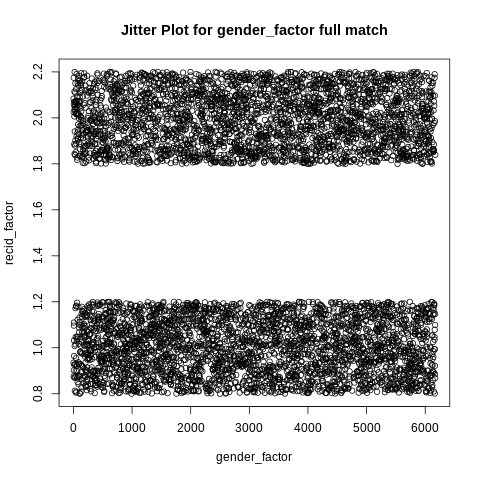

In [ ]:
%%R
# Jitter plots (one for each covariate)
plot(jitter(as.numeric(matched_data_full$recid_factor)),
     xlab = "gender_factor",
     ylab = "recid_factor",
     main = "Jitter Plot for gender_factor full match")


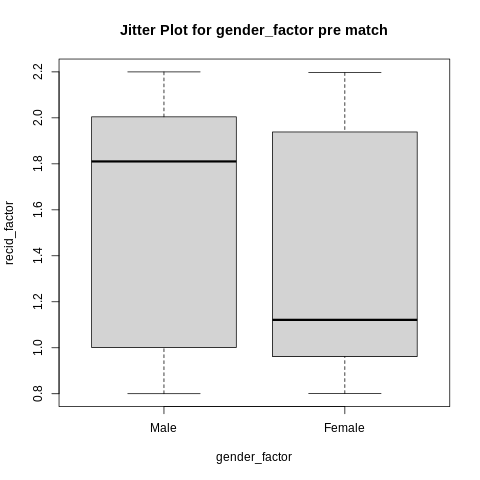

In [ ]:
%%R
plot(jitter(as.numeric(df$recid_factor)) ~ df$gender_factor,
     xlab = "gender_factor",
     ylab = "recid_factor",
     main = "Jitter Plot for gender_factor pre match")

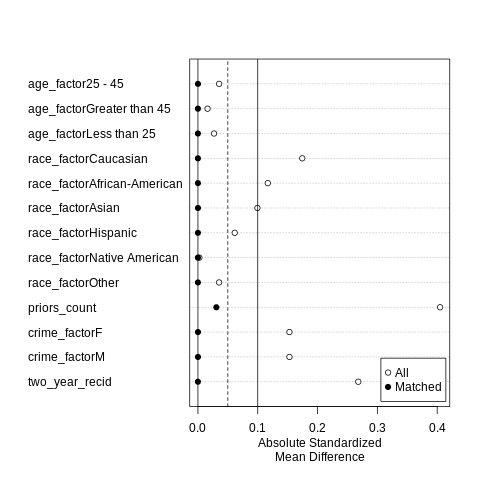

In [ ]:
%%R
plot(summary(coarsened_exact_match))

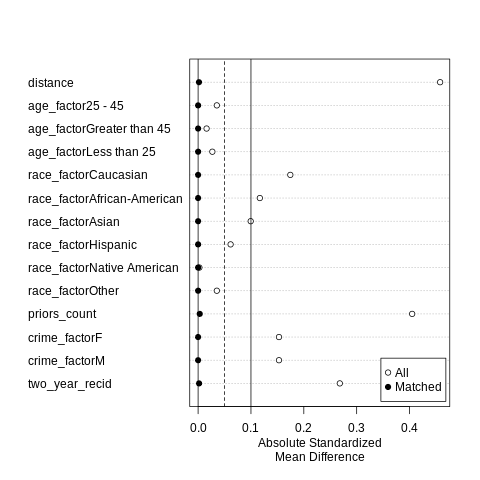

In [ ]:
%%R
plot(summary(genetic_match))

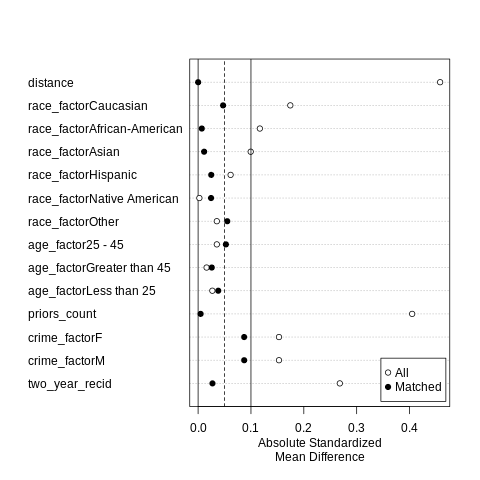

In [ ]:
%%R
plot(summary(full_match))

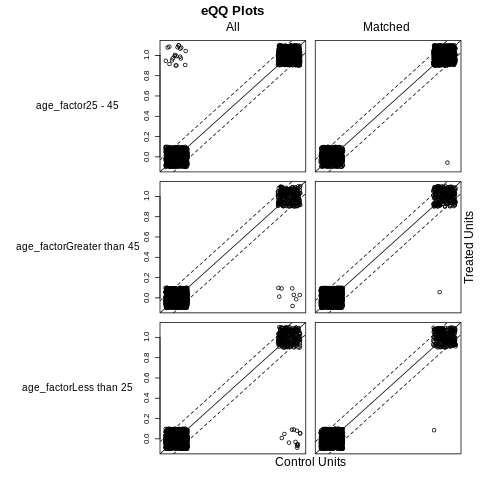

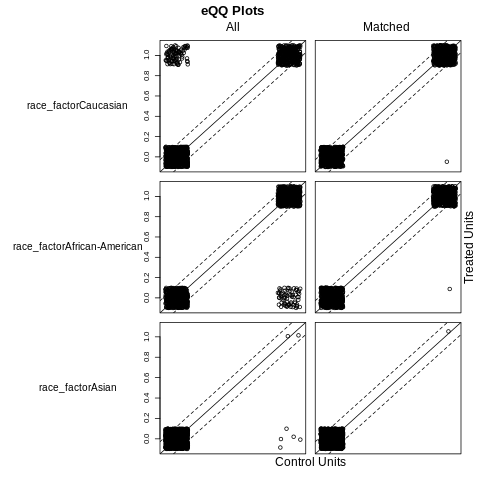

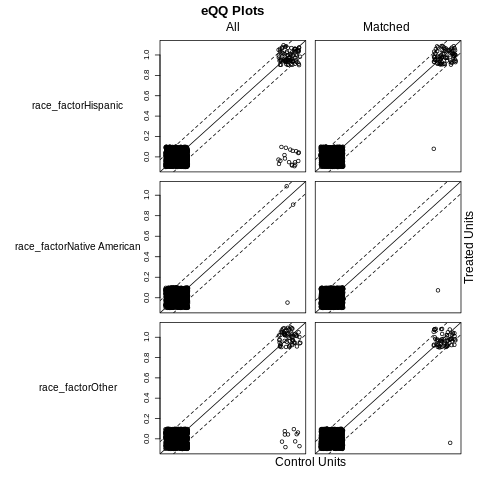

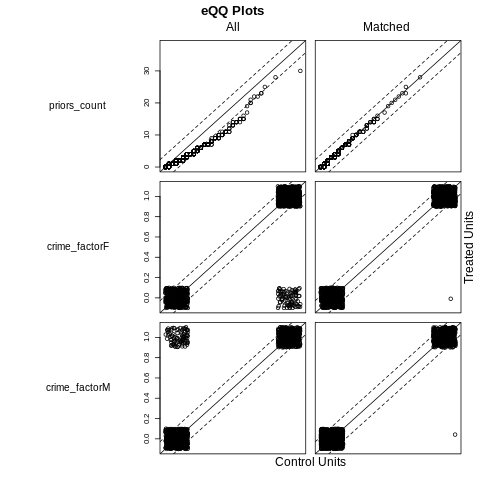

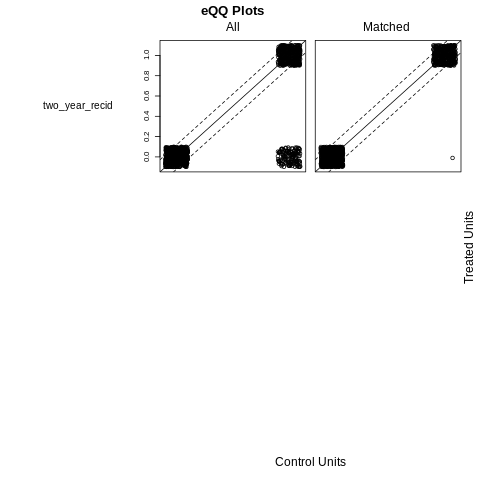

In [ ]:
%%R
plot(
    coarsened_exact_match,
    type = "qq",
    interactive = FALSE)

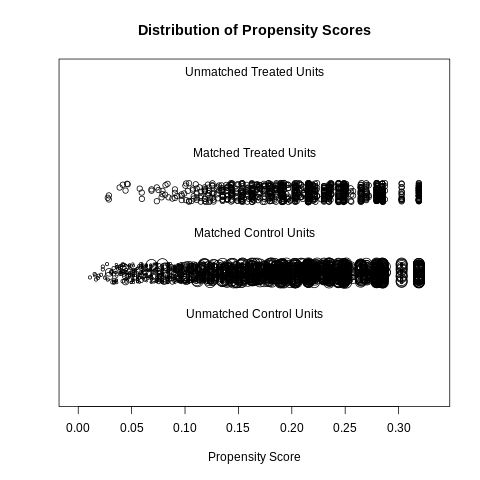

In [ ]:
%%R
plot(full_match, type = "jitter", interactive = FALSE)

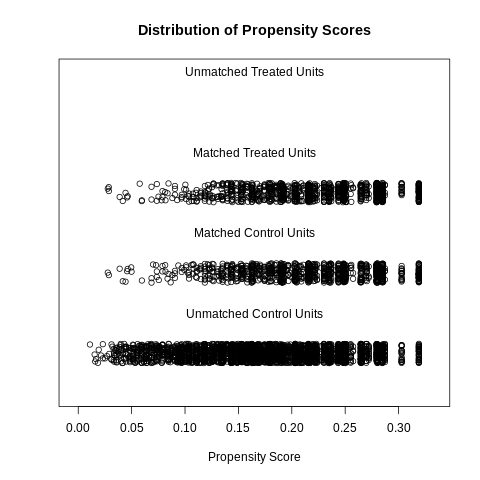

In [ ]:
%%R
plot(genetic_match, type = "jitter", interactive = FALSE)

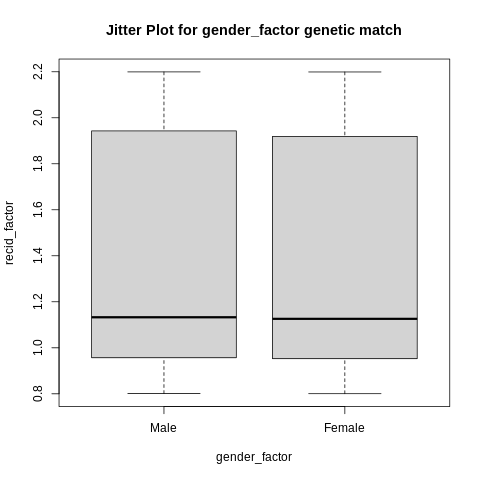

In [ ]:
%%R
# Jitter plots (one for each covariate)
plot(jitter(as.numeric(matched_data_genetic$recid_factor)) ~ matched_data_genetic$gender_factor,
     xlab = "gender_factor",
     ylab = "recid_factor",
     main = "Jitter Plot for gender_factor genetic match")

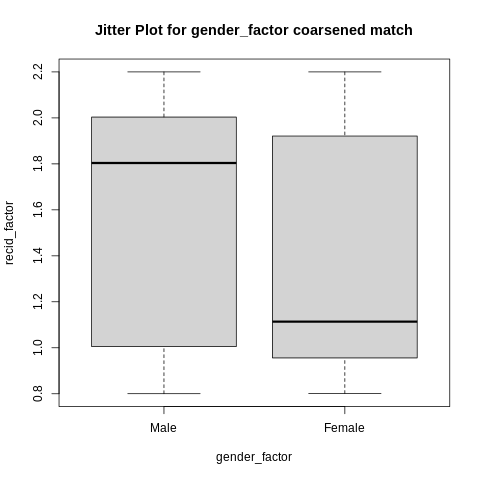

In [ ]:
%%R
# Jitter plots (one for each covariate)
plot(jitter(as.numeric(matched_data_coarsened$recid_factor)) ~ matched_data_coarsened$gender_factor,
     xlab = "gender_factor",
     ylab = "recid_factor",
     main = "Jitter Plot for gender_factor coarsened match")

#Gender FACT Calculation#

In [ ]:
%%R
# FACT calculation full match
# treatment: gender, outcome: recid_factor
model <- matchit(gender_factor ~ race_factor + age_factor + priors_count
                     + crime_factor + two_year_recid, data = df, method = "full")
matched_data <- match.data(model)
weight_vector <- model$weights


# # Fit the weighted regression model
weighted_model <- glm(recid_factor ~ race_factor + gender_factor + age_factor + priors_count
                      + crime_factor + two_year_recid,
                      family = binomial(link = "logit"),
                      data = matched_data,
                      weights = weight_vector)



#weighted_model <- lm(recid_factor ~ race_factor + gender_factor+ age_factor + priors_count + crime_factor + two_year_recid,data = matched_data)
#weighted_model <- lm(recid_factor ~ race_factor + gender_factor + age_factor + priors_count
                      # + crime_factor + two_year_recid, data = matched_data, weights = weight_vector)

# # Obtain coefficients, including the causal effect estimate
# summary(weighted_model)
# estimated_effect <- coef(weighted_model)["treatment"]
# estimated_effect

In [ ]:
%%R
summary(weighted_model)


Call:
glm(formula = recid_factor ~ race_factor + gender_factor + age_factor + 
    priors_count + crime_factor + two_year_recid, family = binomial(link = "logit"), 
    data = matched_data, weights = weight_vector)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -3.51666    0.18286 -19.231  < 2e-16 ***
race_factorAfrican-American   0.60561    0.17388   3.483 0.000496 ***
race_factorAsian              0.59848    1.35777   0.441 0.659372    
race_factorHispanic          -0.85349    0.52048  -1.640 0.101042    
race_factorNative American    3.41205    0.80766   4.225 2.39e-05 ***
race_factorOther              0.66218    0.27374   2.419 0.015561 *  
gender_factorFemale          -0.59108    0.23155  -2.553 0.010690 *  
age_factorGreater than 45    -0.17127    0.19477  -0.879 0.379222    
age_factorLess than 25        0.28283    0.18120   1.561 0.118554    
priors_count                  0.11055    0.02116   5.223 1.76e-07 ***

In [ ]:
%%R
#FACT calcuation for gender
coef(weighted_model)["gender_factorFemale"]

gender_factorFemale 
         -0.5910802 


In [ ]:
%%R
length(weight_vector)
class(weight_vector)
length(weight_vector) == nrow(matched_data)
all(weight_vector > 0)

[1] TRUE


[1] 6172


In [ ]:
%%R
class(matched_data)
# Convert the list to a data frame
matched_df <- data.frame(matched_data)

class(matched_df)

# any(is.na(matched_df))
any(is.nan(unlist(matched_df)))
# any(is.infinite(unlist(matched_df)))
# # # any(is.nan(matched_data))
# # # any(is.infinite(matched_data))

# sapply(matched_data, function(x) any(is.nan(unlist(x))))
# sapply(matched_data, function(x) any(is.infinite(unlist(x))))



[1] FALSE


In [ ]:
%%R
# FACT calculation genetic match
# treatment: gender, outcome: recid_factor
model <- matchit(gender_factor ~ race_factor + age_factor + priors_count
                     + crime_factor + two_year_recid, data = df, method = "genetic")
matched_data <- match.data(model)
weight_vector <- model$weights


# # Fit the weighted regression model
weighted_model <- glm(recid_factor ~ race_factor + gender_factor + age_factor + priors_count
                      + crime_factor + two_year_recid,
                      family = binomial(link = "logit"),
                      data = matched_data,
                      weights = weight_vector)



#weighted_model <- lm(recid_factor ~ race_factor + gender_factor+ age_factor + priors_count + crime_factor + two_year_recid,data = matched_data)
#weighted_model <- lm(recid_factor ~ race_factor + gender_factor + age_factor + priors_count
                      # + crime_factor + two_year_recid, data = matched_data, weights = weight_vector)

# # Obtain coefficients, including the causal effect estimate
# summary(weighted_model)
# estimated_effect <- coef(weighted_model)["treatment"]
# estimated_effect

  variable lengths differ (found for '(weights)')







Error in model.frame.default(formula = recid_factor ~ race_factor + gender_factor +  : 
  variable lengths differ (found for '(weights)')


In [ ]:
%%R
# FACT calculation genetic match
# treatment: gender, outcome: recid_factor
model <- matchit(gender_factor ~ race_factor + age_factor + priors_count
                     + crime_factor + two_year_recid, data = df, method = "cem")
matched_data <- match.data(model)
weight_vector <- model$weights


# Fit the weighted regression model
weighted_model <- glm(recid_factor ~ race_factor + gender_factor + age_factor + priors_count
                      + crime_factor + two_year_recid,
                      family = binomial(link = "logit"),
                      data = matched_data,
                      weights = weight_vector)
coef(weighted_model)["gender_factorFemale"]

  variable lengths differ (found for '(weights)')




Error in model.frame.default(formula = recid_factor ~ race_factor + gender_factor +  : 
  variable lengths differ (found for '(weights)')


In [ ]:
%%R
print(len(weight_vector))

UsageError: Cell magic `%%R` not found.


#Gender FACE Calculation#

In [ ]:
%%R
#FACE for gender

#Calculate Propensity Scores for gender_factor as the treatment
propensity_model_gender <- glm(gender_factor ~ race_factor + age_factor + priors_count + crime_factor + two_year_recid,
                               family = binomial(),
                               data = df)
df$propensity_score_gender <- predict(propensity_model_gender, type = "response")

# Calculate Stabilized Weights for gender_factor
df$weights_gender <- with(df,
                          (propensity_score_gender * (gender_factor == "Male") +
                          (1 - propensity_score_gender) * (gender_factor == "Female")) /
                          propensity_score_gender)

# Perform Weighted Logistic Regression for gender_factor
weighted_model_gender <- glm(recid_factor ~ gender_factor,
                             family = binomial(),
                             data = df,
                             weights = weights_gender)

# View the summary of the model for gender_factor
summary(weighted_model_gender)


Call:
glm(formula = recid_factor ~ gender_factor, family = binomial(), 
    data = df, weights = weights_gender)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
(Intercept)         0.045235   0.028300   1.598    0.110
gender_factorFemale 0.006699   0.039851   0.168    0.866

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13970  on 6171  degrees of freedom
Residual deviance: 13970  on 6170  degrees of freedom
AIC: 14061

Number of Fisher Scoring iterations: 4



#Treatment: Race#

In [ ]:
%%R
# Cleaning data
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count,
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>%
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A') %>%
        filter(race != "Other") %>%
        filter(race != "Hispanic") %>%
        filter(race != "Asian") %>%
        filter(race != "Native American")

In [ ]:
%%R
# Changing variables into factors
df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>%
      mutate(race_factor = factor(race, labels= c("Caucasian", "African-American"))) %>%
      within(race_factor <- relevel(race_factor, ref = 2)) %>%
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
      mutate(recid_factor = factor(is_recid))
model <- glm(recid_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df)
summary(model)


Call:
glm(formula = recid_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -3.19478    0.18818 -16.977  < 2e-16 ***
gender_factorFemale        -0.74503    0.24590  -3.030  0.00245 ** 
age_factorGreater than 45  -0.42465    0.21834  -1.945  0.05178 .  
age_factorLess than 25      0.34842    0.21228   1.641  0.10073    
race_factorCaucasian        0.42327    0.17947   2.358  0.01835 *  
priors_count                0.09084    0.01751   5.189 2.12e-07 ***
crime_factorM               0.17673    0.16966   1.042  0.29755    
two_year_recid             23.21803  346.64640   0.067  0.94660    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7316.8  on 5277  degrees of freedom
Residual deviance: 1193.3

In [ ]:
%%R
# Full matching
full_match <- matchit(race_factor ~ age_factor + gender_factor +
    priors_count + crime_factor + two_year_recid, data=df, method="full")

# Summary of genetic matching
summary(full_match, un = FALSE)


Call:
matchit(formula = race_factor ~ age_factor + gender_factor + 
    priors_count + crime_factor + two_year_recid, data = df, 
    method = "full")

Summary of Balance for Matched Data:
                          Means Treated Means Control Std. Mean Diff.
distance                         0.6395        0.6395         -0.0001
age_factor25 - 45                0.5978        0.5814          0.0334
age_factorGreater than 45        0.1474        0.1498         -0.0068
age_factorLess than 25           0.2548        0.2688         -0.0320
gender_factorMale                0.8271        0.8224          0.0123
gender_factorFemale              0.1729        0.1776         -0.0123
priors_count                     4.2381        4.2008          0.0069
crime_factorF                    0.6917        0.6889          0.0059
crime_factorM                    0.3083        0.3111         -0.0059
two_year_recid                   0.5231        0.5216          0.0032
                          Var. Ratio eCD

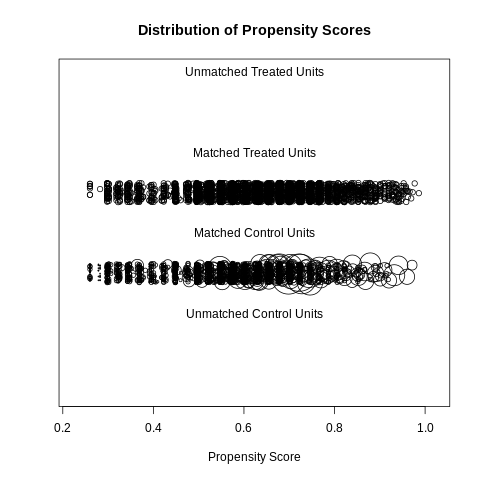

In [ ]:
%%R
plot(full_match, type = "jitter", interactive = FALSE)

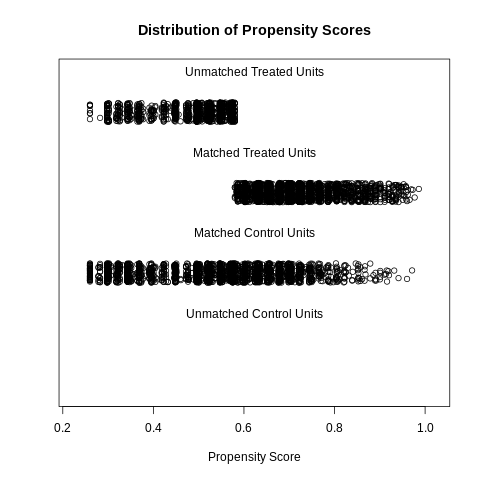

In [ ]:
%%R
plot(genetic_match, type = "jitter", interactive = FALSE)

In [ ]:
%%R
# Genetic matching
genetic_match <- matchit(race_factor ~ age_factor + gender_factor +
    priors_count + crime_factor + two_year_recid, data=df, method="genetic")

# Summary of genetic matching
summary(genetic_match, un = FALSE)


Call:
matchit(formula = race_factor ~ age_factor + gender_factor + 
    priors_count + crime_factor + two_year_recid, data = df, 
    method = "genetic")

Summary of Balance for Matched Data:
                          Means Treated Means Control Std. Mean Diff.
distance                         0.7172        0.5443          1.2446
age_factor25 - 45                0.5521        0.5364          0.0320
age_factorGreater than 45        0.0632        0.2986         -0.6640
age_factorLess than 25           0.3847        0.1650          0.5042
gender_factorMale                0.8692        0.7708          0.2603
gender_factorFemale              0.1308        0.2292         -0.2603
priors_count                     5.7836        2.2891          0.6428
crime_factorF                    0.7737        0.5915          0.3944
crime_factorM                    0.2263        0.4085         -0.3944
two_year_recid                   0.6562        0.3909          0.5312
                          Var. Ratio 

In [ ]:
%%R
# Coarsened exact matching
coarsened_exact_match <- matchit(race_factor ~ age_factor + gender_factor +
    priors_count + crime_factor + two_year_recid, data=df, method="cem")

# Summary of coarsened exact matching
summary(coarsened_exact_match, un = FALSE)


Call:
matchit(formula = race_factor ~ age_factor + gender_factor + 
    priors_count + crime_factor + two_year_recid, data = df, 
    method = "cem")

Summary of Balance for Matched Data:
                          Means Treated Means Control Std. Mean Diff.
age_factor25 - 45                0.5953        0.5953         -0.0000
age_factorGreater than 45        0.1435        0.1435          0.0000
age_factorLess than 25           0.2611        0.2611          0.0000
gender_factorMale                0.8270        0.8270         -0.0000
gender_factorFemale              0.1730        0.1730          0.0000
priors_count                     3.6533        3.5548          0.0181
crime_factorF                    0.6959        0.6959          0.0000
crime_factorM                    0.3041        0.3041          0.0000
two_year_recid                   0.5187        0.5187          0.0000
                          Var. Ratio eCDF Mean eCDF Max Std. Pair Dist.
age_factor25 - 45                  .   

#Race Jitter Plots + Mean Difference Plots#

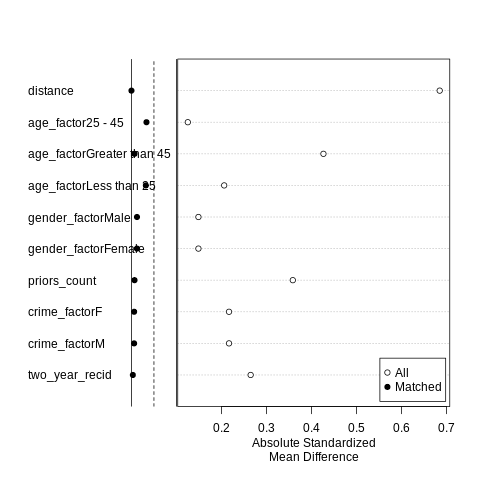

In [ ]:
%%R
plot(summary(full_match))

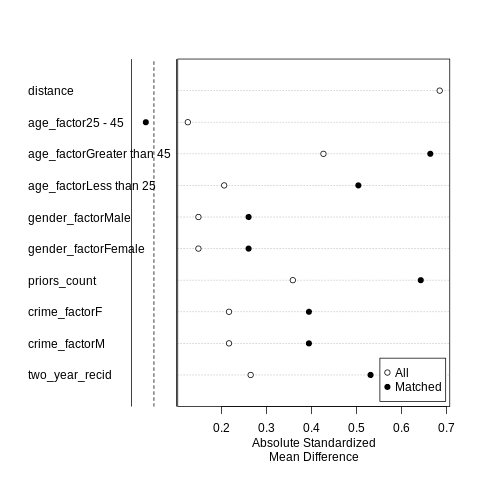

In [ ]:
%%R
plot(summary(genetic_match))

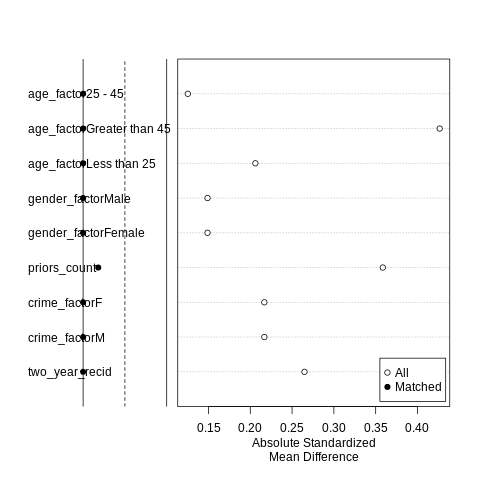

In [ ]:
%%R
plot(summary(coarsened_exact_match))

In [ ]:
%%R
# Extract the matched data
matched_data_full <- match.data(full_match)
matched_data_genetic <- match.data(genetic_match)
matched_data_coarsened <- match.data(coarsened_exact_match)

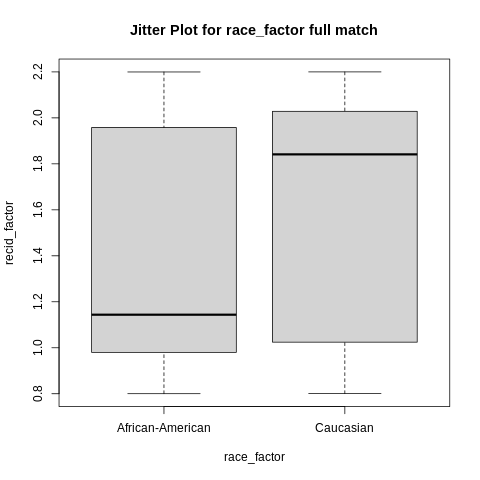

In [ ]:
%%R
# Jitter plots race
plot(jitter(as.numeric(matched_data_full$recid_factor)) ~ matched_data_full$race_factor,
     xlab = "race_factor",
     ylab = "recid_factor",
     main = "Jitter Plot for race_factor full match")


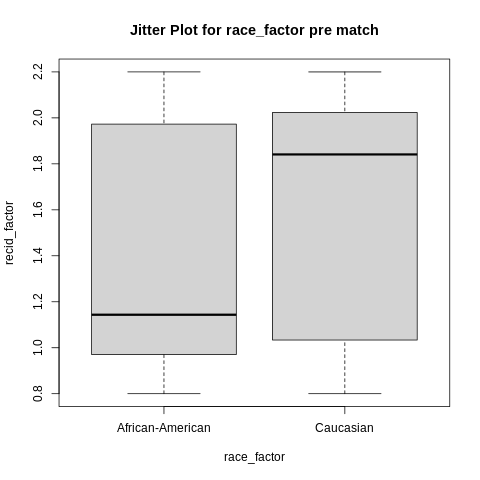

In [ ]:
%%R
# Jitter plots race
plot(jitter(as.numeric(df$recid_factor)) ~ df$race_factor,
     xlab = "race_factor",
     ylab = "recid_factor",
     main = "Jitter Plot for race_factor pre match")

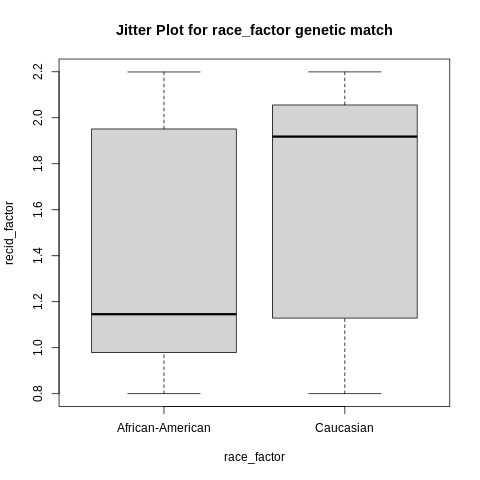

In [ ]:
%%R
# Jitter plots race
plot(jitter(as.numeric(matched_data_genetic$recid_factor)) ~ matched_data_genetic$race_factor,
     xlab = "race_factor",
     ylab = "recid_factor",
     main = "Jitter Plot for race_factor genetic match")

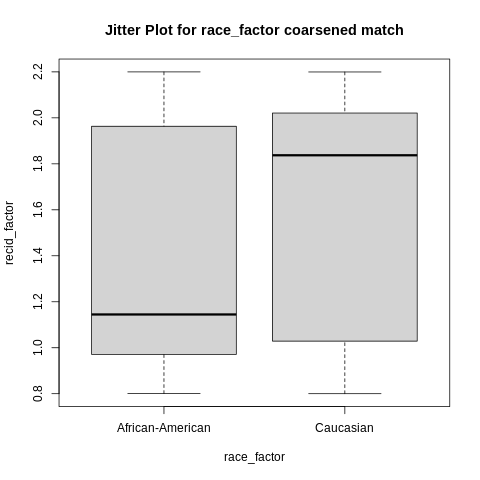

In [ ]:
%%R
# Jitter plots race
plot(jitter(as.numeric(matched_data_coarsened$recid_factor)) ~ matched_data_coarsened$race_factor,
     xlab = "race_factor",
     ylab = "recid_factor",
     main = "Jitter Plot for race_factor coarsened match")

#Race FACT Calculation#

In [ ]:
%%R
# FACT calculation full match
# treatment: race, outcome: recid_factor
model <- matchit(race_factor ~ gender_factor + age_factor + priors_count
                     + crime_factor + two_year_recid, data = df, method = "full")
matched_data <- match.data(model)
weight_vector <- model$weights


# # Fit the weighted regression model
weighted_model <- glm(recid_factor ~ race_factor + gender_factor + age_factor + priors_count
                      + crime_factor + two_year_recid,
                      family = binomial(link = "logit"),
                      data = matched_data,
                      weights = weight_vector)

In [ ]:
%%R
coef(weighted_model)["gender_factorFemale"]

gender_factorFemale 
         -0.7552811 


In [ ]:
%%R
# FACT calculation genetic match
# treatment: race, outcome: recid_factor
model_genetic <- matchit(race_factor ~ gender_factor + age_factor + priors_count
                     + crime_factor + two_year_recid, data = df, method = "genetic")
matched_data_genetic <- match.data(model_genetic)
weight_vector_genetic <- model_genetic$weights

# # Fit the weighted regression model
# weighted_model <- glm(recid_factor ~ race_factor + gender_factor + age_factor + priors_count
#                       + crime_factor + two_year_recid,
#                       # family = binomial(link = "logit"),
#                       data = matched_data,
#                       weights = weight_vector)

In [ ]:
%%R
length(weight_vector_genetic)

[1] 5278


In [ ]:
%%R
nrow(matched_data_genetic)

[1] 4206


In [ ]:
%%R
weighted_model <- glm(recid_factor ~ race_factor + gender_factor + age_factor + priors_count
                      + crime_factor + two_year_recid,
                      family = binomial(link = "logit"),
                      data = matched_data,
                      weights = weight_vector)

  variable lengths differ (found for '(weights)')




Error in model.frame.default(formula = recid_factor ~ race_factor + gender_factor +  : 
  variable lengths differ (found for '(weights)')


In [ ]:
%%R
nrow(df)

[1] 5278


In [ ]:
%%R
head(matched_data)

  age c_charge_degree             race      age_cat score_text    sex
2  24               F African-American Less than 25        Low   Male
3  41               F        Caucasian      25 - 45     Medium   Male
4  39               M        Caucasian      25 - 45        Low Female
5  27               F        Caucasian      25 - 45        Low   Male
6  23               M African-American Less than 25     Medium   Male
7  37               M        Caucasian      25 - 45        Low Female
  priors_count days_b_screening_arrest decile_score is_recid two_year_recid
2            4                      -1            4        1              1
3           14                      -1            6        1              1
4            0                      -1            1        0              0
5            0                      -1            4        0              0
6            3                       0            6        1              1
7            0                       0            1   

In [ ]:
%%R
coef(weighted_model)["gender_factorFemale"]

gender_factorFemale 
         -0.5900949 


#Race FACE Calculation#

In [ ]:
%%R
#FACE calculation for RACE


# Calculate Propensity Scores for race_factor as the treatment
propensity_model_race <- glm(race_factor ~ gender_factor + age_factor + priors_count + crime_factor + two_year_recid,
                             family = binomial(),
                             data = df)
df$propensity_score_race <- predict(propensity_model_race, type = "response")

# Calculate Stabilized Weights for race_factor
df$weights_race <- with(df,
                        (propensity_score_race * (race_factor == "Caucasian") +
                        (1 - propensity_score_race) * (race_factor == "African-American")) /
                        propensity_score_race)

# Perform Weighted Logistic Regression for race_factor
weighted_model_race <- glm(recid_factor ~ race_factor,
                           family = binomial(),
                           data = df,
                           weights = weights_race)

# View the summary of the model for race_factor
summary(weighted_model_race)


Call:
glm(formula = recid_factor ~ race_factor, family = binomial(), 
    data = df, weights = weights_race)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -0.81488    0.04712  -17.29   <2e-16 ***
race_factorCaucasian  1.04965    0.05914   17.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7299.4  on 5277  degrees of freedom
Residual deviance: 6969.4  on 5276  degrees of freedom
AIC: 7018.3

Number of Fisher Scoring iterations: 4

